# Predicting Online Credit Card Applications (Digital Advertising)
*Final Project #4: Modeling Performance*
<br>*Feb 5, 2017*

## Summary of Exploratory Data Analysis

During our EDA, we determined the following insights to guide us in developing our model:
* The event we are planning to predict is very rare:
    * **Conversions per User: 0.0130062273738 %**
* Most features had some positive correlation with our dependent variable, with the exception of the following features:
    * TimeDiff_Days_AVG (Average time between ad impressions)
    * Creative_Type_RichMediaExpanding_Imp
    * Some Creative Sizes
* **Correlated Features**: Many features are heavily correlated with each other. 
* **Outliers:** All of the features in our dataset have outliers at large values (e.g. a user shown more than 1000 impressions over 2 months).  When building our model, we will ignore any users that saw more the 3 standard deviations above the mean of impressions to avoid having outliers bias the model.

## Approach
We will take the follow steps to develop and tune our model:

* We will develop a classifier using **Logistic Regression**.  The reason for choosing this representation is mainly due to the need to develop intuitive explanations of the model to our end client (a non-technical audience).
* We will use **L1 regularization** to reduce the number of features in our model, especially because of many correlated features.
* Our scoring method will be **AUC (Area Under the Curve)**.  We chose AUC because the event we are predicting is rare.  We are adapting this scoring method based on how the medical field uses it to score the quality of signals for rare diseases.
* Finally, we will use our final model to calculate **ROI** and **Net Value** at difference thresholds of the predicted probabilities of our model that we classify a positive prediction.  We will identify the threshold that maximizes **Net Value**.
* Due to the very large size of our dataset, we plan to use a 20% random sample for developing our model.

## Define Business Performance Metrics

While we will use AUC to evaluate the quality of our models, we also want to caclulate business performance metrics of **ROI** and **Net Value**, as defined below.  Our focus will be to increase **Net Value** from an ad campaign, but we will also calculate ROI for reference.

To calculate these metrics, we need define how we will interpret the confusion matrix:

|True Class: Positive|True Class: Negative
------------------------------|:-------------:|:-------------:
**Predicted Class: Positive** |True Positives |False Positives
**Predicted Class: Negative** |False Negatives|True Negatives

Since we plan to use our model to predict how we should design our ad campaigns, we can interpret the predicted class to help us identify whether or not we'd like to reach users with a similar ad exposure:
* Positive Predicted Class: Spend on user because of high likelihood to convert
* Negative Predicted Calls: **Do not** spend on user
For example, if we predict a positive class for an observation in our dataset that was reached by 10 video ads and 15 display ads, we would plan on spending on similar users like this in the future.

Based on this interpretation, we can develop a cost-benefit methodology based on the confusion matrix:

|True Class: Positive|True Class: Negative
-----------------------------|:------------------------------------------:|:-------------:
**Predicted Class Positive** |Application Value<br>- Cost of Reaching User|-Cost of Reaching User
**Predicted Class Negative** |0|0
**Assumptions:**
* **ApplicationValue** = \$500 (The average value of a credit card application)
* **ReachCost** = \$0.033827 (The average cost of reaching a single user for our campaign)


Using this interpretation allows us to define the following **ROI** and **Net Value** functions:

\begin{equation*}
ROI = \frac{Total Value}{Total Cost} - 1
\end{equation*}

\begin{equation*}
Net Value = Total Value - Total Cost
\end{equation*}

\begin{equation*}
Total Value = ApplicationValue * TP
\end{equation*}

\begin{equation*}
Total Cost = ReachCost * (TP + FP)
\end{equation*}

Once we have determined our best estimator with AUC and `gridsearchsv`, we can then tune our **threshold** for a postive signal based on the predicted probability from our logistic regression model.  We will tune the **threshold** to maximize **Net Value**.

## Important Data and Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sk_modelcurves.learning_curve import draw_learning_curve
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
data = pd.read_csv('../data/DATA_FOR_MODEL_20perc.csv', sep=',')
#data = pd.read_csv('../data/DATA_FOR_MODEL_FULL.csv', sep=',')
data.head(10)

,User_ID,Impressions,TimeDiff_Minutes,TimeDiff_Minutes_AVG,Funnel_Upper_Imp,Funnel_Middle_Imp,Funnel_Lower_Imp,Campaign_Message_Travel_Imp,Campaign_Message_Service_Imp,Campaign_Message_Family_Travel_Imp,...,Creative_Size_320x480_Imp,Creative_Size_Uknown_Imp,Device_Desktop_Imp,Device_Other_Imp,Device_Mobile_Imp,Active_View_Eligible_Impressions,Active_View_Measurable_Impressions,Active_View_Viewable_Impressions,Clicks,Conversions
0,AMsySZYlP3l94iys9P9WaBXIWE6B,3,2.0,1.000000,0,3,0,0,3,0,...,0,0,0,0,3,0,0,0,NaN,NaN
1,AMsySZbdCy7kK0BqCq38AvgzDJ7y,3,1.0,0.500000,0,3,0,3,0,0,...,0,0,3,0,0,3,3,1,NaN,NaN
2,AMsySZbsx0jjk_iOfpRCVx2ss3v8,2,12.0,12.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
3,AMsySZZnAR-zSA0aCGVZkfhupUhU,5,23033.0,5758.250000,0,5,0,0,0,0,...,0,0,0,0,5,5,5,5,NaN,NaN
4,AMsySZb1yHw6ewPTnb7h39vBdCh8,2,188.0,188.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
5,AMsySZbMUcclS_w01crSZ23CgZsa,1,NaN,NaN,0,1,0,0,0,0,...,0,0,0,0,1,1,1,0,NaN,NaN
6,AMsySZbN3U0Y-dpMwJBHb5KWpB6S,444,73303.0,165.469526,0,85,359,283,161,0,...,0,85,444,0,0,359,359,314,NaN,NaN
7,AMsySZZYbLJhgekE6XQ52ea1bpKb,2,80.0,80.000000,0,2,0,0,0,0,...,0,0,2,0,0,2,2,1,NaN,NaN
8,AMsySZaWJ0IyUoZmTqnYg4_LsylU,1,NaN,NaN,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,NaN,NaN
9,AMsySZbQxjkNdQtKIjG1m3fso1u_,9,56231.0,7028.875000,0,9,0,0,0,0,...,0,0,0,0,9,7,7,3,NaN,NaN


## Handle Missing Data

In [3]:
# For Clicks,Conversion, convert NULL values to zero
data['Clicks'].fillna(value=0,inplace=True)
data['Conversions'].fillna(value=0,inplace=True)

# Create a new categorical feature Converted, which will be 1 if the the user converted at least once, 
# and 0 if the user did not convert.
data['Converted'] = pd.Categorical([1 if x>0 else 0 for x in data['Conversions']])

# For TimeDiff_Minutes and TimeDiff_AVG, it is NULL when we only have 1 impression
# For now, replace with the median value and then add columns flagging the rows where we did this
# We will explore other options for handling this data in the feature engineering section
data['TimeDiff_NULL_FLAG'] = pd.Categorical(data['TimeDiff_Minutes'].isnull())

data['TimeDiff_Minutes'].fillna(value=data['TimeDiff_Minutes'].median(),inplace=True)
data['TimeDiff_Minutes_AVG'].fillna(value=data['TimeDiff_Minutes_AVG'].median(),inplace=True)

In [4]:
# confirm no nulls left dataset
data.isnull().sum()

User_ID                                 0
Impressions                             0
TimeDiff_Minutes                        0
TimeDiff_Minutes_AVG                    0
Funnel_Upper_Imp                        0
Funnel_Middle_Imp                       0
Funnel_Lower_Imp                        0
Campaign_Message_Travel_Imp             0
Campaign_Message_Service_Imp            0
Campaign_Message_Family_Travel_Imp      0
Campaign_Card_Cash_Rewards_Imp          0
Campaign_Card_Premium_Rewards_Imp       0
Campaign_Card_Other_Imp                 0
Creative_Type_Display_Imp               0
Creative_Type_TrueView_Imp              0
Creative_Type_RichMediaExpanding_Imp    0
Creative_Type_RichMedia_Imp             0
Creative_Size_728x90_Imp                0
Creative_Size_300x600_Imp               0
Creative_Size_300x250_Imp               0
Creative_Size_160x600_Imp               0
Creative_Size_468x60_Imp                0
Creative_Size_300x50_Imp                0
Creative_Size_320x50_Imp          

In [5]:
#Show the distribution of impressions
data['Impressions'].describe()

count    3.036639e+06
mean     4.895185e+00
std      1.600795e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.600000e+03
Name: Impressions, dtype: float64

In [6]:
#Remove outliers (users with more than ~50 impressions, 3 standard devs above the mean of 4.9 impressions)
print max(data['Impressions'])
data = data[data['Impressions']<=50]
print max(data['Impressions'])

5600
50


In [7]:
X=data.drop(['User_ID','Conversions','Converted'],axis=1)
y=data['Converted']

In [8]:
# Split into Train/Test 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

## Business Performance Functions and Baseline Benchmark

In [9]:
# Define ROI function
# *See section "Define Business Performance Metrics" for more details
def ROI(y,y_pred,app_value,avg_user_cost):
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=y_pred).ravel()
    
    total_value=float(tp*app_value)
    total_cost=float((tp+fp)*avg_user_cost)
    ROI=total_value/total_cost-1
    
    return ROI

In [10]:
# Define Net Value function
# *See section "Define Business Performance Metrics" for more details
def Net_Value(y,y_pred,app_value,avg_user_cost):
    tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=y_pred).ravel()
    
    total_value=float(tp*app_value)
    total_cost=float((tp+fp)*avg_user_cost)
    Net_Value=total_value-total_cost
    
    return Net_Value

#### Basline Performance
Get baseline performance by assuming our classified producted "1" (or "positive") for all of our dataset observations.
**NOTE:** Baseline benchmark should be calculated on test dataset.

In [11]:
# Assumptions:
#    Value of credit card application=$500
#    Avg cost of reaching a user=$0.033827
ROI_benchmark = ROI(y=y_test,
                    y_pred=np.ones(y_test.size),
                    app_value=500,
                    avg_user_cost=0.033827)
Net_Value_benchmark = Net_Value(y=y_test,
                                y_pred=np.ones(y_test.size),
                                app_value=500,
                                avg_user_cost=0.033827)

In [12]:
print "Baseline Net Value: {0:.0f}".format(Net_Value_benchmark)
print "Baseline ROI: {0:.1f}%".format(ROI_benchmark*100)

Baseline Net Value: 15690
Baseline ROI: 77.3%


## L1 Logistic Regression - All Existing Features

Use L1 regularization with Logistic Regression to Identify Important/Non-Important features

In [13]:
# Standardization: bring all of our features onto the same scale
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [14]:
# Cross-validation: 5 cross validation iterations with 30% test / 70% train
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

In [15]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.01,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 18min 31s, sys: 45 s, total: 19min 16s
Wall time: 18min 34s


In [16]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.731113147939


**Notes**
* **AUC of 0.7311** is a "Fair" quality model
* Good start, but we will see if we can improve this score with some new features
* Before that, we will:
    * Review the current model coefficients
    * Plot distribution of predicted 
    * Draw the learning curve
    * Plot the ROC against the Test data for reference

#### Show Coefficients

In [17]:
best_logreg = clf.best_estimator_

In [18]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':best_logreg.coef_[0]})

In [19]:
# Show non-important / zero'd features
best_coeff[best_coeff['Coefficients']==0]

,Coefficients,Features
0,0.0,Impressions
2,0.0,TimeDiff_Minutes_AVG
3,0.0,Funnel_Upper_Imp
6,0.0,Campaign_Message_Travel_Imp
7,0.0,Campaign_Message_Service_Imp
12,0.0,Creative_Type_Display_Imp
13,0.0,Creative_Type_TrueView_Imp
14,0.0,Creative_Type_RichMediaExpanding_Imp
15,0.0,Creative_Type_RichMedia_Imp
16,0.0,Creative_Size_728x90_Imp


In [20]:
#Show important features - save for later use
kept_coeff=best_coeff[best_coeff['Coefficients']!=0]
kept_coeff

,Coefficients,Features
1,0.064723,TimeDiff_Minutes
4,-0.396818,Funnel_Middle_Imp
5,0.054933,Funnel_Lower_Imp
8,0.085187,Campaign_Message_Family_Travel_Imp
9,0.006751,Campaign_Card_Cash_Rewards_Imp
10,-0.049596,Campaign_Card_Premium_Rewards_Imp
11,0.021680,Campaign_Card_Other_Imp
22,-0.042018,Creative_Size_320x50_Imp
23,0.006210,Creative_Size_320x420_Imp
27,0.129389,Device_Desktop_Imp


#### Draw Learning Curve

CPU times: user 4min 19s, sys: 23.8 s, total: 4min 43s
Wall time: 4min 6s


<module 'matplotlib.pyplot' from '//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

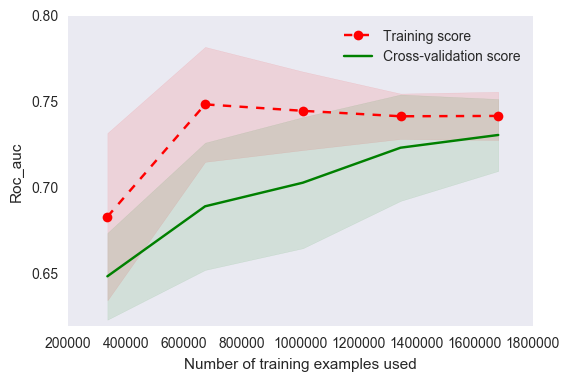

In [21]:
%%time
draw_learning_curve(best_logreg, pd.DataFrame(X_train_std), pd.Series(y_train), scoring='roc_auc', cv=cv);

**Notes:**
* The flattening of the training score curve shows we likely would not get more value from more data
* We do see the variance of the cross-validation score increase which could lead to overfitting
* We also have some bias as the training set only reaches ~.76 AUC, which indicates that we could improve the model with additional features.

#### Plot distribution of Predicted Probabilities

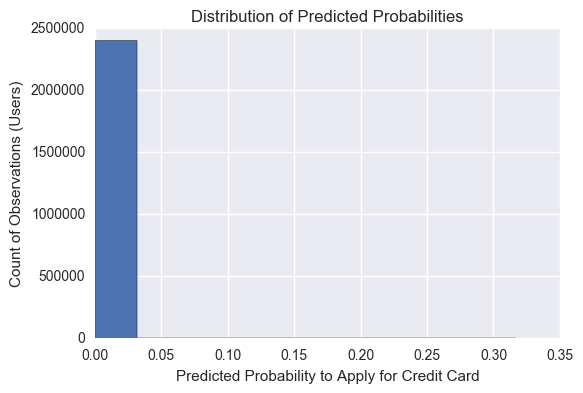

In [22]:
#Distribution of predictions
y_probs = best_logreg.predict_proba(X_train_std)[:,1]
plt.hist(y_probs)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability to Apply for Credit Card")
plt.ylabel("Count of Observations (Users)");

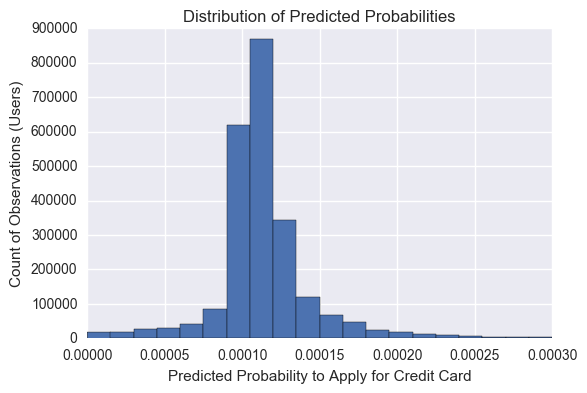

In [23]:
#Distribution of predictions (Zoom in at probabilites<0.03%)
max_in_chart=0.0003
plt.hist(y_probs[y_probs<max_in_chart],bins=20);
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability to Apply for Credit Card")
plt.ylabel("Count of Observations (Users)");

**Notes**
* The large peak in the middle is an indication of how how hard it is to distinquish our observations from each other
* However, there is a long tail to the right as seen in the first graph

#### Plot ROC/AUC on Test Dataset (Reference Point)

In [128]:
#Plot ROC
y_probs_test=best_logreg.predict_proba(X_test_std)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_test)
plt.plot(fpr,tpr,label='Initial Best Model ROC')

#Plot reference line
z=np.linspace(0,1,20)
plt.plot(z,z,label='Baseline');

#Calculate AUC
area=auc(fpr, tpr)
plt.text(0.5, 0.3, 'AUC={0:0.4f}'.format(area), style='normal',
         verticalalignment='center', horizontalalignment='center',
         bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

# AUC shading
plt.fill_between(fpr, 0, tpr, where=tpr >= 0, facecolor='lightblue', interpolate=True,alpha=0.5)

#Plot details
plt.title("ROC on Test Data")
plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Postive Rate (TPR)")
plt.legend(loc='right');

ValueError: X has 13 features per sample; expecting 35

**Notes**
* AUC slightly improved from 0.7311 (Training Data cross-validation) to 0.7508 on the Test Data
* We will keep this as a reference point to try to improve by adding new features in the next section

## Try New Features

We will create the following new features to try improve our model score:
1. Funnel Halo Effect
2. Categorical version of TimeDiff (time difference between first and last ad)
3. Percent Viewable Impressions
4. Combine Creative Sizes into buckets of Small, Medium, and Large

### 1. Funnel Halo Effect
We believe there is a potential halo effect from being reached by multiple stages of the marketing funnel.  Therefore, we will create 4 new features to capture these overlaps in ad exposure:
* Upper_and_Lower
* Upper_and_Middle
* Middle_Lower
* Upper_Middle_Lower

In [27]:
# Create new features
data['Upper_and_Lower'] = data['Funnel_Upper_Imp']*data['Funnel_Lower_Imp']
data['Upper_and_Middle'] = data['Funnel_Upper_Imp']*data['Funnel_Middle_Imp']
data['Middle_Lower'] = data['Funnel_Middle_Imp']*data['Funnel_Lower_Imp']
data['Upper_Middle_Lower'] = data['Funnel_Upper_Imp']*data['Funnel_Middle_Imp']*data['Funnel_Lower_Imp']

In [145]:
# Re-prepare the Features dataset
# Keep only the features we found are important in our L1 regularization in our first model
# Add new features
features=kept_coeff['Features'].tolist() + ['Upper_and_Lower','Upper_and_Middle','Middle_Lower','Upper_Middle_Lower']
X=data[features]

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [146]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.01,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 8min 36s, sys: 27.6 s, total: 9min 4s
Wall time: 8min 24s


In [147]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.733026754188


In [152]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

,Coefficients,Features
0,0.064403,TimeDiff_Minutes
1,-0.399255,Funnel_Middle_Imp
2,0.052844,Funnel_Lower_Imp
3,0.084410,Campaign_Message_Family_Travel_Imp
4,0.005709,Campaign_Card_Cash_Rewards_Imp
5,-0.050107,Campaign_Card_Premium_Rewards_Imp
6,0.021560,Campaign_Card_Other_Imp
7,-0.041603,Creative_Size_320x50_Imp
8,0.006205,Creative_Size_320x420_Imp
9,0.134881,Device_Desktop_Imp


**Notes**
* Small improvement in AUC from 0.7311 tot 0.7330
* Minimual Improvemnt to AUC and the only feature add was "Upper_and_Lower" with a very low coefficient, perhaps not worth adding to final model

### 2. Alternative Time-Difference Feature
Change Time-Difference Feature to be categorical, with the following breakouts:
* **Only One Impression:** User only received 1 impression (use this value as the reference point, don't include in model)
* **TimeDiff_One_Day:** Mulitple Impressions in one day
* **TimeDiff_1to7_Days:** Mulitple Impressions in one week (but more than a single day)
* **TimeDiff_7plus:** Multiple Impressions over several days (more than one week)

In [28]:
# Create new features
data['TimeDiff_One_Day'] = pd.Categorical( (data['Impressions']>1) &
                                           (data['TimeDiff_Minutes']<= (24*60)) ) 
data['TimeDiff_1to7_Days'] = pd.Categorical( (data['Impressions']>1) &
                                             (data['TimeDiff_Minutes']> (24*60)) & 
                                            (data['TimeDiff_Minutes']<= (24*60*7)) )
data['TimeDiff_7plus'] = pd.Categorical( (data['Impressions']>1) &
                                             (data['TimeDiff_Minutes']> (24*60*7)) )

In [50]:
data[['Impressions','TimeDiff_Minutes','TimeDiff_One_Day','TimeDiff_1to7_Days','TimeDiff_7plus']].sample(10)

,Impressions,TimeDiff_Minutes,TimeDiff_One_Day,TimeDiff_1to7_Days,TimeDiff_7plus
1449060,1,1481.0,False,False,False
1181194,9,4608.0,False,True,False
2269738,1,1481.0,False,False,False
1946283,1,1481.0,False,False,False
2030945,3,8884.0,False,True,False
2775876,2,1.0,True,False,False
3015205,1,1481.0,False,False,False
1604817,4,211.0,True,False,False
1870112,1,1481.0,False,False,False
2728273,15,64870.0,False,False,True


In [51]:
# Re-prepare the Features dataset
# Keep only the features we found are important in our L1 regularization in our first model
# Replace time features with new ones
features=kept_coeff['Features'].tolist() + ['TimeDiff_One_Day','TimeDiff_1to7_Days','TimeDiff_7plus'] 
X=data[features]
X=X.drop(['TimeDiff_Minutes','TimeDiff_NULL_FLAG'],axis=1)

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [52]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.01,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 7min 3s, sys: 26.2 s, total: 7min 29s
Wall time: 6min 52s


In [53]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.1}
Best AUC model score is: 0.727869693493


In [54]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

,Coefficients,Features
0,-0.688399,Funnel_Middle_Imp
1,0.013938,Funnel_Lower_Imp
2,0.207509,Campaign_Message_Family_Travel_Imp
3,0.070059,Campaign_Card_Cash_Rewards_Imp
4,-0.057239,Campaign_Card_Premium_Rewards_Imp
5,0.023785,Campaign_Card_Other_Imp
6,-0.122755,Creative_Size_320x50_Imp
7,0.009637,Creative_Size_320x420_Imp
8,0.139749,Device_Desktop_Imp
9,-0.291493,Device_Other_Imp


**Notes**
* AUC slightly worsened from 0.7311 to 0.7278 (minimal difference)
* This representation is slightly more intuitive, perhaps keep this one.

### 3. Percent of Impressions Viewable
We believe that the percent of impressions shown that were viewable could potentially be an important feature.  Viewable_Percent will be defined as:

\begin{equation*}
ViewablePercent = \frac{ViewableImpressions}{MeasurableImpressions}
\end{equation*}

In [29]:
# Create new features
data['Viewable_Percent'] = data['Active_View_Viewable_Impressions'] / data['Active_View_Measurable_Impressions']

# Replace NULL/inf with zero (when measureable imp=0)
data['Viewable_Percent'].fillna(0,inplace=True)
data['Viewable_Percent']=data['Viewable_Percent'].replace(np.inf,0)

# Some data issues may cause negative values or values above 1
# For negative values, change to 0
# For values above 1, change to 1
data['Viewable_Percent']=[0 if x<0 else x for x in data['Viewable_Percent']]
data['Viewable_Percent']=[1 if x>1 else x for x in data['Viewable_Percent']]

In [79]:
print max(data['Viewable_Percent'])
print min(data['Viewable_Percent'])

1.0
0.0


In [80]:
data[['Active_View_Viewable_Impressions','Active_View_Measurable_Impressions','Viewable_Percent']].sample(5)

,Active_View_Viewable_Impressions,Active_View_Measurable_Impressions,Viewable_Percent
2724085,0,0,0.0
2648956,2,4,0.5
1896920,4,8,0.5
2046039,6,20,0.3
2202346,1,1,1.0


In [81]:
# Re-prepare the Features dataset
# Keep only the features we found are important in our L1 regularization in our first model
# Replace time features with new ones
features=kept_coeff['Features'].tolist() + ['Viewable_Percent'] 
X=data[features]

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [82]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.01,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 5min 50s, sys: 25.1 s, total: 6min 15s
Wall time: 6min 15s


In [83]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.733110067906


In [87]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

,Coefficients,Features
0,0.064722,TimeDiff_Minutes
1,-0.396829,Funnel_Middle_Imp
2,0.054921,Funnel_Lower_Imp
3,0.085190,Campaign_Message_Family_Travel_Imp
4,0.006752,Campaign_Card_Cash_Rewards_Imp
5,-0.049593,Campaign_Card_Premium_Rewards_Imp
6,0.021681,Campaign_Card_Other_Imp
7,-0.042019,Creative_Size_320x50_Imp
8,0.006210,Creative_Size_320x420_Imp
9,0.129397,Device_Desktop_Imp


**Notes:**
* The new **Viewable_Percent** feature did not make it past regularization

### 4. Alternative Creative Size Representation
Instead of using each creative size as a separate feature, we can bucket the sizes by Small, Medium, and Large. Create new features as the **summation** of the creative size features.  We are using summation because each feature represents the impresions from that creative size, so if we group them together, we can sum the impressions.

* **Small Creative Sizes:**
    * Creative_Size_300x50_Imp
    * Creative_Size_320x50_Imp
    * Creative_Size_468x60_Imp
* **Medium Creative Sizes:**
    * Creative_Size_160x600_Imp
    * Creative_Size_300x250_Imp
    * Creative_Size_728x90_Imp
* **Large Creative Sizes:**
    * Creative_Size_300x600_Imp
    * Creative_Size_320x420_Imp
    * Creative_Size_320x480_Imp
    * Creative_Size_480x320_Imp
* **Creative_Size_Uknown_Imp**

In [30]:
# Create new features
data['Creative_Small'] = data['Creative_Size_300x50_Imp'] + data['Creative_Size_468x60_Imp'] \
                        +data['Creative_Size_320x50_Imp']
data['Creative_Medium'] = data['Creative_Size_160x600_Imp'] + data['Creative_Size_300x250_Imp']  \
                        + data['Creative_Size_728x90_Imp']
data['Creative_Large'] = data['Creative_Size_300x600_Imp'] + data['Creative_Size_320x420_Imp'] \
                        + data['Creative_Size_320x480_Imp'] + data['Creative_Size_480x320_Imp']

In [124]:
# Re-prepare the Features dataset
# Keep only the features we found are important in our L1 regularization in our first model
# Replace creative size features with new ones
features=kept_coeff['Features'].tolist() + ['Creative_Small','Creative_Medium','Creative_Large',
                                            'Creative_Size_Uknown_Imp']
X=data[features]
X=X.drop(['Creative_Size_728x90_Imp','Creative_Size_300x600_Imp','Creative_Size_300x250_Imp',
         'Creative_Size_160x600_Imp','Creative_Size_468x60_Imp','Creative_Size_300x50_Imp',
         'Creative_Size_320x420_Imp','Creative_Size_480x320_Imp','Creative_Size_320x480_Imp',
         'Creative_Size_320x50_Imp'],
       axis=1,
       errors='ignore')

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [125]:
%%time
logregL1 = LogisticRegression(penalty='l1')
parameters = {'C': [0.01,0.05,0.1,0.3,0.5]}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 6min 48s, sys: 26 s, total: 7min 14s
Wall time: 7min 14s


In [126]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'C': 0.05}
Best AUC model score is: 0.733389193866


In [127]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':clf.best_estimator_.coef_[0]})
best_coeff

,Coefficients,Features
0,0.064237,TimeDiff_Minutes
1,-0.398032,Funnel_Middle_Imp
2,0.053679,Funnel_Lower_Imp
3,0.083942,Campaign_Message_Family_Travel_Imp
4,0.008109,Campaign_Card_Cash_Rewards_Imp
5,-0.051690,Campaign_Card_Premium_Rewards_Imp
6,0.021762,Campaign_Card_Other_Imp
7,0.131341,Device_Desktop_Imp
8,-0.078691,Device_Other_Imp
9,-0.106923,Device_Mobile_Imp


**Notes:**
* AUC slightly improved from 0.7311 to 0.7334
* The only new feature that was included was **Creative_Small**, with slightly negative influence
* This representation is slightly more intuitive, perhaps keep this one.

## Final Model (Including New Features)
Based on our exploration of new features, we will try include the new New TimeDiff Features only.  This time we will tree to use both L1 and L2 to see which one produces the best model.

#### Find Best Model

In [58]:
features=[
'Funnel_Middle_Imp',
'Funnel_Lower_Imp',
'Campaign_Message_Family_Travel_Imp',
'Campaign_Card_Cash_Rewards_Imp',
'Campaign_Card_Premium_Rewards_Imp',
'Campaign_Card_Other_Imp',
'Device_Desktop_Imp',
'Device_Other_Imp',
'Device_Mobile_Imp',
'Clicks',
'TimeDiff_One_Day','TimeDiff_1to7_Days','TimeDiff_7plus']

In [59]:
X=data[features]

# Split into Train/Test (random state ensures same breakdown)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# Standardization: bring all of our features onto the same scale
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [60]:
%%time
logregL1 = LogisticRegression()
parameters = {'C': [0.01,0.05,0.1,0.3,0.5],
              'penalty':['l1','l2']}
clf = GridSearchCV(logregL1, parameters, cv=cv,scoring="roc_auc")
clf.fit(pd.DataFrame(X_train_std), pd.Series(y_train))   #turning into pandas dataframe or series prevents an error

CPU times: user 8min 57s, sys: 37 s, total: 9min 34s
Wall time: 9min 32s


In [61]:
print "Best model parameters are: {}".format(clf.best_params_)
print "Best AUC model score is: {}".format(clf.best_score_)

Best model parameters are: {'penalty': 'l2', 'C': 0.01}
Best AUC model score is: 0.735014886649


* 0.7350 is slight improvement over 0.7311

In [70]:
final_model=clf.best_estimator_

In [71]:
best_coeff=pd.DataFrame({'Features':X.columns,
                         'Coefficients':final_model.coef_[0]})
best_coeff

,Coefficients,Features
0,-0.127673,Funnel_Middle_Imp
1,0.039189,Funnel_Lower_Imp
2,0.038157,Campaign_Message_Family_Travel_Imp
3,0.023612,Campaign_Card_Cash_Rewards_Imp
4,-0.022039,Campaign_Card_Premium_Rewards_Imp
5,0.019738,Campaign_Card_Other_Imp
6,0.041219,Device_Desktop_Imp
7,-0.043009,Device_Other_Imp
8,-0.026827,Device_Mobile_Imp
9,0.009595,Clicks


#### Intuitive Explanation of Features

In [69]:
# Calculate Odds Ratios 
# For intuitive understanding of coefficients
#kept_coeff['Odds_Ratios']=
final_features=pd.concat([best_coeff,best_coeff['Coefficients'].apply(np.exp)],axis=1)
final_features.columns=['Coefficients','Features','OddsRatio']
final_features

,Coefficients,Features,OddsRatio
0,-0.127673,Funnel_Middle_Imp,0.880141
1,0.039189,Funnel_Lower_Imp,1.039967
2,0.038157,Campaign_Message_Family_Travel_Imp,1.038895
3,0.023612,Campaign_Card_Cash_Rewards_Imp,1.023893
4,-0.022039,Campaign_Card_Premium_Rewards_Imp,0.978202
5,0.019738,Campaign_Card_Other_Imp,1.019934
6,0.041219,Device_Desktop_Imp,1.042080
7,-0.043009,Device_Other_Imp,0.957903
8,-0.026827,Device_Mobile_Imp,0.973529
9,0.009595,Clicks,1.009642


**Interpretation**
For every standard deviation increase of 1 in the feature, there is the following increase in the odds for applying for a credit card.  For example:
* ~12% decrease in odds with a 1 standard deviation increase in Funnel_Middle_Imp
* ~7.8% increase in odds with a 1 standard deviation increase in TimeDiff_7plus

#### Plot ROC/AUC on Test Dataset (Final Model)

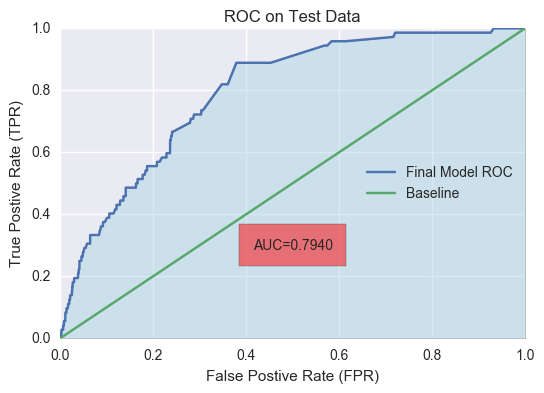

In [127]:
#Plot Final Model ROC
y_probs_test=final_model.predict_proba(X_test_std)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_test)
plt.plot(fpr,tpr,label='Final Model ROC')

#Plot reference line
z=np.linspace(0,1,20)
plt.plot(z,z,label='Baseline')

#Calculate AUC
area=auc(fpr, tpr)
plt.text(0.5, 0.3, 'AUC={0:0.4f}'.format(area), style='normal',
         verticalalignment='center', horizontalalignment='center',
         bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

# AUC shading
plt.fill_between(fpr, 0, tpr, where=tpr >= 0, facecolor='lightblue', interpolate=True,alpha=0.5)

#Plot details
plt.title("ROC on Test Data")
plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Postive Rate (TPR)")
plt.legend(loc='right');

**Notes:**
* AUC for Initial Model: 0.7508
* AUC for Final Model: 0.7940

Adding new features and switching to L2 regularization helped improve the AUC score against test data.  ~Fair/Good Model.

#### Draw Relationship X & Y vs Probabilty to Apply for Credit Card

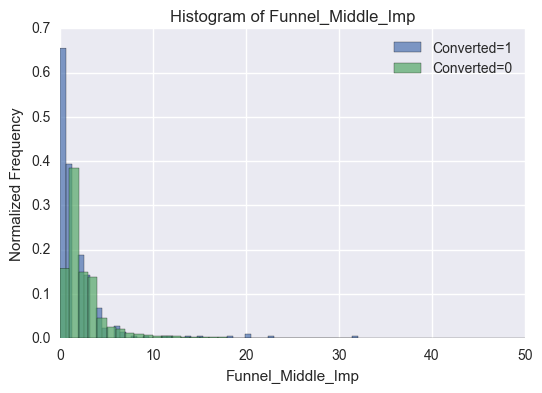

In [95]:
# Plot Funnel_Middle_Imp Histogragam
plt.hist(data.loc[data["Converted"]==1,'Funnel_Middle_Imp'],alpha=0.7,label="Converted=1",normed=True,bins=50)
plt.hist(data.loc[data["Converted"]==0,'Funnel_Middle_Imp'],alpha=0.7,label="Converted=0",normed=True,bins=50)
plt.legend()
plt.title("Histogram of Funnel_Middle_Imp")
plt.xlabel("Funnel_Middle_Imp")
plt.ylabel("Normalized Frequency");

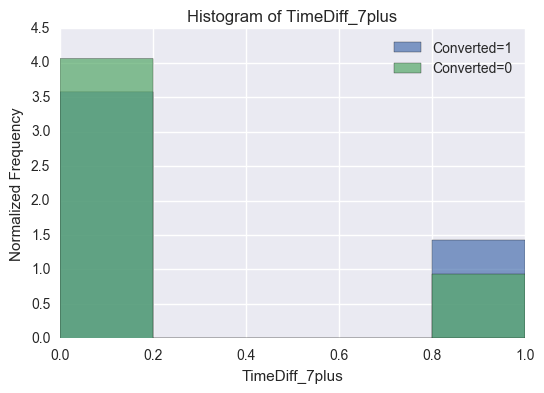

In [106]:
# Plot Funnel_Middle_Imp Histogragam
plt.hist(data.loc[data["Converted"]==1,'TimeDiff_7plus'],alpha=0.7,label="Converted=1",normed=True,bins=5)#
plt.hist(data.loc[data["Converted"]==0,'TimeDiff_7plus'],alpha=0.7,label="Converted=0",normed=True,bins=5)
plt.legend()
plt.title("Histogram of TimeDiff_7plus")
plt.xlabel("TimeDiff_7plus")
plt.ylabel("Normalized Frequency");

## Business Metrics on Final Model

With our final model, we now want to determine **ROI** and **Net Value** at various thresholds for the probability to convert for which we'd be willing to spend on our ad campaign.  We will use these graphs to determine the threshold that maximizes **Net Value**.

In [107]:
# Make Dataframe with the threshold value corresponding to the TPR and FPR in the ROC curve
roc_df = pd.DataFrame({'thresholds':thresholds,
                       'tpr':tpr,
                       'fpr':fpr}, columns=['thresholds','tpr','fpr'])
roc_df.head()

,thresholds,tpr,fpr
0,1.020387,0.0,0.000000
1,0.020387,0.0,0.000002
2,0.009091,0.0,0.000023
3,0.007893,0.0,0.000027
4,0.004824,0.0,0.000052


In [115]:
#For 100 threshold values between 0 and 1, get closest corresponding TPR/FPR
breakouts=100
roc_cuts=None
roc_cuts=pd.DataFrame()
for i in range(0,breakouts):
    threshold_cut = i/float(breakouts)+0.1
    temp=roc_df[roc_df['tpr']<=threshold_cut].sort_values(by='thresholds',ascending=True).head(1)
    roc_cuts=pd.concat([roc_cuts,temp])
roc_cuts.head(10)

,thresholds,tpr,fpr
2229,0.000641,0.097222,0.017031
2229,0.000641,0.097222,0.017031
2560,0.000618,0.111111,0.019859
2750,0.000606,0.125000,0.021535
3161,0.000585,0.138889,0.025444
3161,0.000585,0.138889,0.025444
3244,0.000581,0.152778,0.026264
3328,0.000578,0.166667,0.027068
3328,0.000578,0.166667,0.027068
3596,0.000566,0.180556,0.030142


In [114]:
%%time
#Calculate ROI and Net Values for all 100 different thresholds between 0 and 1
ROIs=[]
Net_Values=[]
for i in range(0,breakouts):
    prob_threshold=roc_cuts.iloc[i,0]
    scores = final_model.predict_proba(X_test_std)[:,1]
    y_pred = [1 if x>=prob_threshold else 0 for x in scores]
    
    ROIs.append(ROI(y=y_test,y_pred=y_pred,app_value=500,avg_user_cost=0.033827))
    Net_Values.append(Net_Value(y=y_test,y_pred=y_pred,app_value=500,avg_user_cost=0.033827))

CPU times: user 2min 24s, sys: 5.79 s, total: 2min 30s
Wall time: 2min 29s


In [181]:
business_metrics=pd.DataFrame({'Thresholds':roc_cuts['thresholds'],
                       'tpr':roc_cuts['tpr'],
                       'fpr':roc_cuts['fpr'],
                       'ROI':ROIs,
                       'Net_Value':Net_Values})
business_metrics.head()

,Net_Value,ROI,Thresholds,fpr,tpr
2229,3153.915963,9.113151,0.000641,0.017031,0.097222
2229,3153.915963,9.113151,0.000641,0.017031,0.097222
2560,3596.443890,8.911881,0.000618,0.019859,0.111111
2750,4062.380101,9.282896,0.000606,0.021535,0.125000
3161,4482.954305,8.670325,0.000585,0.025444,0.138889


**Notes on Charts:**
* Plot Net Values and ROI vs TPR (True Positive Rate)
* How high can we make TPR (by lowering the threshold) to maximize these values?

#### Net Value

In [170]:
Max_Net_Value=max(business_metrics['Net_Value'])
business_metrics_MaxNV=business_metrics[business_metrics['Net_Value']==Max_Net_Value].head(1)

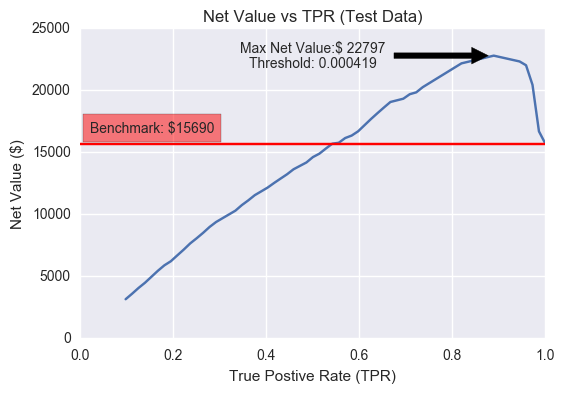

In [199]:
# Plot Net Values vs True Positive Rate
plt.plot(business_metrics['tpr'],business_metrics['Net_Value'])
plt.annotate('Max Net Value:$ {:.0f}\nThreshold: {:.6f}'.format(Max_Net_Value,
                                                                business_metrics_MaxNV['Thresholds'].values[0]),
             xy=(business_metrics_MaxNV['tpr'],Max_Net_Value),
             xytext=(0.5, Max_Net_Value), 
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')

# Plot Benchmark
zx=np.linspace(0,1,20)
zy=np.multiply(np.ones(20),Net_Value_benchmark)
plt.plot(zx,zy,color='red')
plt.text(0.02, Net_Value_benchmark+700, 'Benchmark: ${0:.0f}'.format(Net_Value_benchmark), style='normal',
         verticalalignment='bottom', horizontalalignment='left',
         bbox={'facecolor':'red', 'alpha':0.5, 'pad':5})

#Plot details
plt.title("Net Value vs TPR (Test Data)")
plt.xlabel("True Postive Rate (TPR)")
plt.ylabel("Net Value ($)");

#### ROI

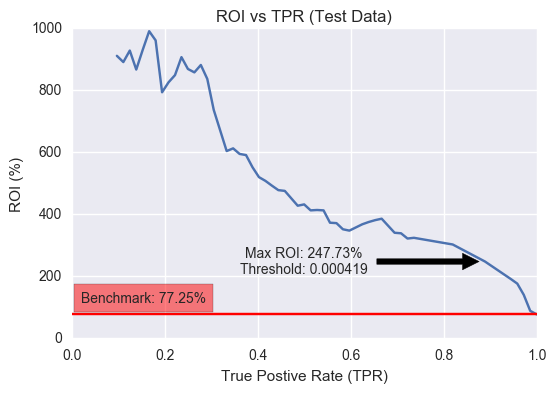

In [223]:
# Plot Net Values vs True Positive Rate
plt.plot(business_metrics['tpr'],business_metrics['ROI']*100)
plt.annotate('Max ROI: {:.2f}%\nThreshold: {:.6f}'.format(business_metrics_MaxNV['ROI'].values[0]*100,
                                                         business_metrics_MaxNV['Thresholds'].values[0]),
             xy=(business_metrics_MaxNV['tpr'],business_metrics_MaxNV['ROI'].values[0]*100),
             xytext=(0.5, business_metrics_MaxNV['ROI'].values[0]*100), 
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')

# Plot Benchmark
zx=np.linspace(0,1,20)
zy=np.multiply(np.ones(20),ROI_benchmark*100)
plt.plot(zx,zy,color='red')
plt.text(0.02, ROI_benchmark*100+30, 'Benchmark: {0:.2f}%'.format(ROI_benchmark*100), style='normal',
         verticalalignment='bottom', horizontalalignment='left',
         bbox={'facecolor':'red', 'alpha':0.5, 'pad':5})

#Plot details
plt.title("ROI vs TPR (Test Data)")
plt.xlabel("True Postive Rate (TPR)")
plt.ylabel("ROI (%)");

In [219]:
business_metrics_MaxNV['ROI'].values[0]*100

247.73031488421245

**Notes**
* Using a threshold of 0.000419 on our classifier, we can apply new logic for how to reach users with our ad campaign (based on past data) to maximize Net Value.
* As a result:
    * We can increase Net Value by **45% to \$22,797** (test data only)
    * We can increase ROI from **77% to 248%** (when maximizing Net Value).  There is room for even better ROI, but that would limit our Net Value.

## Conclusion

When evaluated on test data, our final Logistic Regression classified score a 0.794 in AUC (Area Under the Curve), scores our predicted probalities from our classifier as a "Fair" quality signal for identifying users likely to apply for a credit card.

Our original call was to determine which features of the ads shown to users influence their likelihood to apply for a credit card.  Using the model we tuned, we can then review the coefficients from our model to determin the features that have the strongest infleunce on the predicted probabilities of applying.

Some surpising results were that the following features were not included in our model:
* Viewability
* Upper Funnel and Funnel Halo Effect
* Creative Type

Also surprising were the negative coefficients for these features:
* It is interesting that our Middle Funnel impressions actually a user less likely to convert.  This makes me believe that we are seeing the result with something else that is correlated with a user being shown more Middle Funnel ads (e.g. they are naturally less inclined to apply because they aren not actively searching, which would place them in the Lower Funnel of marketing campaign). We may possibly want to remove the Funnel features in the future.

**Next Steps:**
Based on our learning curve, it is possile that we are seeing a lot of bias due to noise in our data.  One potential way to address this is to find new features that are more predictive of the credit card applications.  We could try more feature engineering, but I would also plan to use additinal features we did not have available for this data (which could be possible in the feature), such as:
* What "audience" is a user from
* What site was the ad seen on:
    * Site category
    * Site quality (In Comscore's top 1000 sites?)